In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import time
from multiprocessing import Pool

from scipy import sparse
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

# Read Data

In [11]:
import pandas as pd
import gzip
import json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df_og = getDF('Data/AMAZON_FASHION.json.gz')

## Changing column names

In [12]:
df = df_og
df.columns = [
 'rating', #'overall',
 'verified',
 'reviewTime',
 'user', #'reviewerID',
 'item', #'asin',
 'reviewerName',
 'reviewText',
 'summary',
 'unixReviewTime',
 'vote',
 'style',
 'image']

In [13]:
df_og.head()

,rating,verified,reviewTime,user,item,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2.0,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3,NaN,NaN
2,4.0,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN
3,2.0,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN
4,3.0,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN


## Read data with styles

In [22]:
df = pd.read_pickle('Data/amazon_data_with_styles')

In [23]:
# df = pd.read_csv('Data/amazon_fashion.csv', names=['item','user','rating'])

## Read Meta Deta

In [24]:
from urllib.request import urlopen
data = []
with gzip.open('Data/m_AMAZON_FASHION.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

df_meta = pd.DataFrame.from_dict(data)

## Thresholds

In [25]:
item_thres = 1
user_thres = 1

In [26]:
df['#ratings'] = df.groupby('item')['item'].transform('count')
df = df[df['#ratings'] >= item_thres].drop(columns=['#ratings'])

df['#ratings'] = df.groupby('user')['user'].transform('count')
df = df[df['#ratings'] >= user_thres].drop(columns=['#ratings'])

## Subset of data

In [27]:
norpu = df.groupby('user')['rating'].count().mean()
total_users = df.user.unique().size
total_items = df.item.unique().size

In [28]:
df = df.sample(frac=0.1, random_state=1234)

# Data Exploration

In [20]:
norpu = df.groupby('user')['rating'].count().mean()
total_users = df.user.unique().size
total_items = df.item.unique().size

rows  883636 
#ratings 883636 
#ratings/user 1.18 
average rating 3.91 
#users  749233 
#items  186189


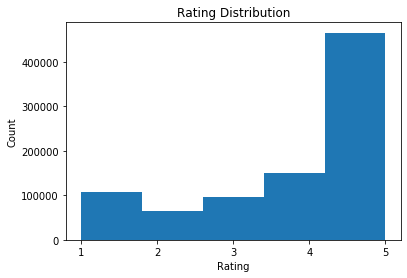

In [99]:
print('rows ', len(df), '\n#ratings', len(df[df['rating'] != 0]), '\n#ratings/user', round(norpu,2), '\naverage rating', "{0:.2f}".format(np.average(df['rating'])), '\n#users ', total_users, '\n#items ', total_items)
df.hist(column='rating', bins=5, grid=False)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(range(1,6))
plt.show()

## Features: Add Style
Expanding the style dict to become columns of df

In [285]:
keys = []
for style in df_og['style']:
    if style is not np.nan:
        keys.extend(list(style.keys()))
keys = list(set(keys))

In [286]:
def add_style(x):
    style_dict = x['style']
    result = []
    for key in keys:
        if style_dict is np.nan:
            result.append(np.nan)
        else:
            result.append(style_dict.get(key))
    return result

In [30]:
df_styles = df.apply(add_style, axis=1, result_type='expand')
df_styles.columns = keys

In [31]:
df = df.merge(df_styles, left_index=True, right_index=True)
df.head()

,rating,verified,reviewTime,user,item,reviewerName,reviewText,summary,unixReviewTime,vote,...,Team Name:,Length:,Material:,Item Package Quantity:,Scent Name:,Gem Type:,Shape:,Format:,Style Name:,Package Quantity:
0,5.0,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Style analysis

In [1]:
plt.rcParams['figure.figsize'] = [10,8]
bars = plt.bar(keys, style_perc_present)
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + 0.005, keys[i])
plt.title('Percentage of data labeled with style')
plt.xticks('')
plt.show()

NameError: name 'plt' is not defined

In [215]:
color_keys = list(df.groupby('Color:')['rating'].count().sort_values(ascending=False)[0:35].index) 

color_perc_present = []
for value in df.groupby('Color:')['rating'].count().sort_values(ascending=False)[0:35]:
    color_perc_present.append(value / (len(df) - df['Color:'].isnull().sum()))

color_keys.append('Others')
color_perc_present.append((df.groupby('Color:')['rating'].count().sort_values(ascending=False)[35:]/(len(df) - df['Color:'].isnull().sum())).sum())

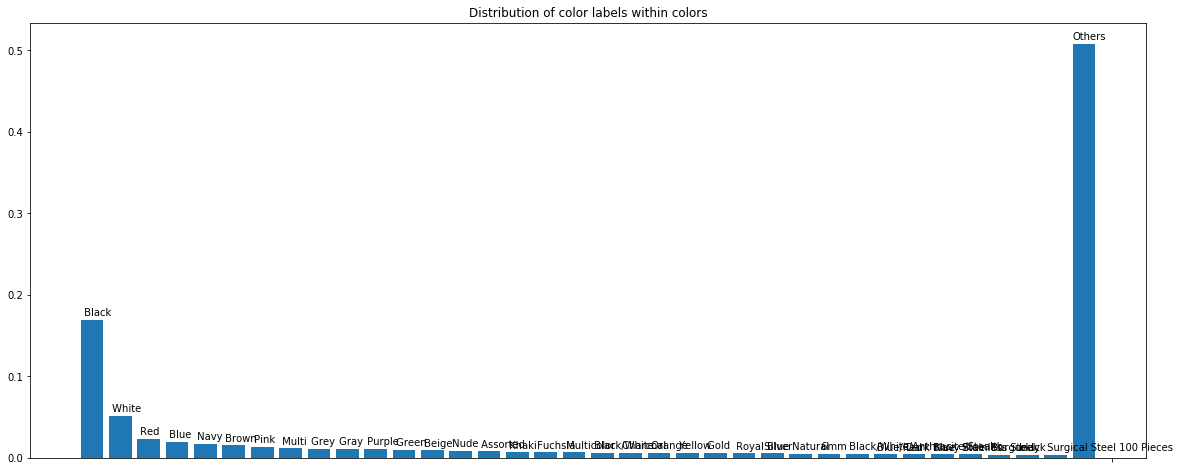

In [216]:
plt.rcParams['figure.figsize'] = [20,8]
bars = plt.bar(color_keys, color_perc_present)
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + 0.005, color_keys[i])
plt.title('Distribution of color labels within colors')
plt.xticks('')
plt.show()

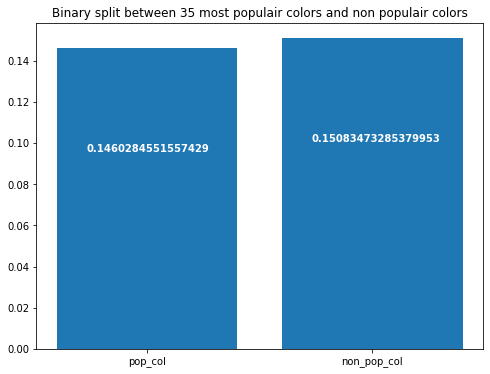

In [219]:
plt.rcParams['figure.figsize'] = [8,6]
pop_col = (df.groupby('Color:')['rating'].count().sort_values(ascending=False)[0:35]/len(df)).sum()
non_pop_col = (df.groupby('Color:')['rating'].count().sort_values(ascending=False)[35:]/len(df)).sum()

bars = plt.bar(['pop_col', 'non_pop_col'], [pop_col, non_pop_col])
plt.text(bars[0].get_x() + 0.13, pop_col + -0.05, pop_col, color="white", fontweight = 'bold')
plt.text(bars[1].get_x() + 0.13, non_pop_col + -0.05, non_pop_col, color="white", fontweight = 'bold')
plt.title('Binary split between 35 most populair colors and non populair colors')
plt.show()

In [230]:
pop_colors = df.groupby('Color:')['rating'].count().sort_values(ascending=False)[0:35] 

def pop_color(x):
    x = x['Color:']
    if x in pop_colors:
        return 1
    elif x not in pop_colors:
        return 0
    else:
        return False

In [245]:
temp_df = pd.DataFrame()

In [246]:
temp_df['bin_pop_col'] = df.apply(pop_color, axis=1, result_type='expand')

In [250]:
df = df.merge(temp_df, left_index=True, right_index=True)

In [251]:
df.head(10)

,rating,verified,reviewTime,user,item,reviewerName,reviewText,summary,unixReviewTime,vote,...,Length:,Material:,Item Package Quantity:,Scent Name:,Gem Type:,Shape:,Format:,Style Name:,Package Quantity:,bin_pop_col
0,5.0,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2.0,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,4.0,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2.0,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,3.0,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5,5.0,True,"07 19, 2014",A29HLOUW0NS0EH,7106116521,Patricia R. Erwin,Exactly what I wanted.,Five Stars,1405728000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6,4.0,True,"05 31, 2014",A7QS961ROI6E0,7106116521,REBECCA S LAYTON,These little plastic backs work great. No mor...,Works great!,1401494400,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
7,3.0,True,"09 22, 2013",A1BB77SEBQT8VX,B00007GDFV,Darrow H Ankrum II,mother - in - law wanted it as a present for h...,bought as a present,1379808000,NaN,...,None,None,None,None,None,None,None,None,None,1
8,3.0,True,"07 17, 2013",AHWOW7D1ABO9C,B00007GDFV,rosieO,"Item is of good quality. Looks great, too. But...",Buxton heiress collection,1374019200,NaN,...,None,None,None,None,None,None,None,None,None,1
9,3.0,True,"04 13, 2013",AKS3GULZE0HFC,B00007GDFV,M. Waltman,I had used my last el-cheapo fake leather ciga...,Top Clasp Broke Within 3 days!,1365811200,NaN,...,None,None,None,None,None,None,None,None,None,1


# The Model

In [29]:
class SVD:
    """" All functions used to run, test, plot and store the
    Singular Value Decomposition Model"""

    def __init__(self, params):
        self.nolf = params['nolf']
        self.n_epochs = params['n_epochs']
        self.alpha = params['alpha']
        self.alpha_b = params['alpha_b']
        self.use_bias = params['use_bias']
        self.use_impl_fb = params['use_impl_fb']
        self.use_i_attributes = params['use_i_attributes']
        self.bu_reg = params['bu_reg']
        self.bi_reg = params['bi_reg']
        self.pu_reg = params['pu_reg']
        self.qi_reg = params['qi_reg']
        self.x_reg = params['x_reg']
        self.random_state = params['random_state']
        self.params = params
        self.mu = 0 
        self.N = []

        self.train_data = pd.DataFrame()
        self.train_matrix = 0
        self.test_data = pd.DataFrame()
        self.train_time = 0
        self.model = {}
        self.test_results = {}
        self.test_int = 0

    def fit(self, train_data, total_users, total_items, verbose = 1, val_set=[]):
        self.SVD(train_data, val_set, total_users, total_items, verbose)
        return self

    def SVD(self, train_data, val_set, total_users, total_items, verbose, plot=True):
        """"The SVD algorithm with sgd
        input: rating dataset with columns:['rating', 'user_id', 'item_id']
        output: the resulting p, q, bi, bu matrices"""
        
        self.mu = create_mu(train_data)
        self.train_data = train_data
        self.total_users = total_users
        self.total_items = total_items
        
        tuples_train = [tuple(x) for x in train_data[['new_user_id', 'new_item_id', 'rating']].to_numpy()]
        b_user = np.zeros(total_users)
        b_item = np.zeros(total_items)

        p = np.random.normal(0, .1, (total_users, self.nolf))  # users
        q = np.random.normal(0, .1, (total_items, self.nolf))  # items

        x = np.random.normal(0,.1, (total_items, self.nolf)) # implicit fb rated, not rated
        impl_fb_u = np.zeros(self.nolf)
        
        y = np.random.normal(0,.1, (total_users, self.nolf)) # item attribute: populair color vs non-pop color
        attr_fb_i = np.zeros(self.nolf)
        
        if self.use_impl_fb:
            print('Creating N, for incorporating implicit feedback')
            self.N = train_data.groupby('new_user_id')['new_item_id'].apply(list)
        
        rmses = []
        val_rmses = []
        val_rmse = "na"
        start = time.time()
        print('Start training')
        for epoch in range(self.n_epochs):
            
            total_sq_error = 0
            for u, i, r_ui in tuples_train:
                u = int(u)
                i = int(i)
            
                if self.use_impl_fb:        
                    impl_fb_u = np.zeros(self.nolf)
                    sqrt_Nu = np.sqrt(len(self.N[u]))
                    for j in self.N[u]:
                        r_uj = train_matrix[u,j]
#                         r_uj = list(train_data[(train_data['new_item_id'] == j) & (train_data['new_user_id'] == u)]['rating'])
                        if r_uj > 0:
                            if r_uj < self.mu + b_user[u]:
                                impl_fb_u -= x[j] / sqrt_Nu
                            if r_uj > self.mu + b_user[u]:
                                impl_fb_u += x[j] / sqrt_Nu
                        
#                 if self.use_i_attribute:
#                     attr_fb_i = np.zeros(self.nolf)
#                     for a in 
                    
                if self.use_bias:
                    error = r_ui - ((self.mu + b_user[u] + b_item[i]) + np.dot((p[u] + impl_fb_u), q[i]))
                    b_user[u] += self.alpha_b * (error - self.bu_reg * b_user[u])
                    b_item[i] += self.alpha_b * (error - self.bi_reg * b_item[i])
                else:
                    error = r_ui - np.dot(p[u], q[i])

                p[u] += self.alpha * (error * q[i] - self.pu_reg * p[u])
                q[i] += self.alpha * (error * (p[u] + impl_fb_u) - self.qi_reg * q[i])
                
                if self.use_impl_fb:
                    for j in self.N[u]:
                        x[j] += self.alpha * (error * q[i] / sqrt_Nu - self.x_reg * x[j])
                
                total_sq_error += np.square(error)

            rmse = np.sqrt(total_sq_error / len(tuples_train))
            rmses.append(rmse)
            
            self.model = {'p': p, 'q': q, 'bu':b_user, 'bi':b_item, 'x':x, 'rmse':rmses, 'val_rmse':val_rmses}
            if len(val_set) > 0:
                val_rmse = self.test(val_set, val=True)
                val_rmses.append(val_rmse)
                    
            if epoch % verbose == 0:
                if len(val_set) > 0:
                    print('Epoch:', epoch, '  RMSE:', rmse, ' Val_RMSE:', val_rmse)
                else:
                    print('Epoch:', epoch, '  RMSE:', rmse)

        if plot:
            self.plot_rmse(rmses, val_rmses)

        self.train_time += time.time() - start
        
    def create_mu(self, train_set):
        # Better mean calculation according to https://sifter.org/~simon/journal/20061211.html
        va = train_set.groupby('new_user_id')['rating'].mean().var() #variance mean ratings users
        vb = train_set.groupby('new_item_id')['rating'].mean().var() #variance mean ratings items
        k = va/vb #variance proportion
        better_mu = (train_set['rating'].mean() + train_set['rating'].sum()) / (k+len(train_set))
        return better_mu
    
    def plot_rmse(self, rmse, val_rmses=[]):
        plt.plot(np.arange(self.n_epochs), rmse)
        if len(val_rmses) > 0:
            plt.plot(np.arange(self.n_epochs), val_rmses, color='red')
        plt.title('RMSE')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['Train', 'Validation'])
        plt.show()
        
    def test(self, test_data, val=False):
        if not val:
            self.test_data = test_data
        tuples_test = [tuple(x) for x in test_data[['new_user_id', 'new_item_id', 'rating']].to_numpy()]

        if self.use_impl_fb:
            self.N = test_data.groupby('new_user_id')['new_item_id'].apply(list)
            
        total_error = 0
        estimates = []
        for u, i, r_ui in tuples_test:
            u = int(u)
            i = int(i)
            est = self.estimate(u, i)
            estimates.append(est)
            total_error += np.square(r_ui - est)
        
        rmse = np.sqrt(total_error / len(tuples_test))
        
        if not val:
            self.test_results = {'rmse': rmse, 'estimates':estimates}
            print('RMSE on test set:', self.test_results['rmse'])
            return self.test_results
        
        return rmse

    def estimate(self, u, i):
        est = self.mu + self.model['bu'][u] + self.model['bi'][i]
        impl_fb_u = np.zeros(self.nolf)
        
        if u in self.train_data['new_user_id'] and i in self.train_data['new_item_id']:
            
            if self.use_impl_fb and u in self.N.index:
                for j in self.N[u]:   
                    impl_fb_u += self.model['x'][j] / np.sqrt(len(self.N[u]))

            est += np.dot(self.model['p'][u] + impl_fb_u, self.model['q'][i])

        return est
    
    def store_results(self, log_path, res_name, user_thres=np.nan, item_thres=np.nan):
        result_info = {'RMSE_test': self.test_results['rmse'], 'train_speed': round(self.train_time,2)}
        other_info = {'u_thres': user_thres,'i_thres': item_thres, 'train_size':len(self.train_data), 'test_size':len(self.test_data), 'train_rmse':self.model['rmse']}
        final_log = dict(result_info, **self.params, **other_info)

        if not os.path.exists(log_path + res_name):
            df_results = pd.DataFrame(columns=final_log.keys())
            print('new results created')

        else:
            df_results = pd.read_pickle(log_path + res_name)
            print('results added')

        df_results = df_results.append(final_log, ignore_index=True)
        pd.to_pickle(df_results, log_path + res_name)
        
hide_toggle()

NameError: name 'hide_toggle' is not defined

In [30]:
class SVD:
    """" All functions used to run, test, plot and store the
    Singular Value Decomposition Model"""

    def __init__(self, params, total_users, total_items):
        self.nolf = params['nolf']
        self.n_epochs = params['n_epochs']
        self.alpha = params['alpha']
        self.alpha_b = params['alpha_b']
        self.use_bias = params['use_bias']
        self.use_impl_fb = params['use_impl_fb']
        self.bu_reg = params['bu_reg']
        self.bi_reg = params['bi_reg']
        self.pu_reg = params['pu_reg']
        self.qi_reg = params['qi_reg']
        self.x_reg = params['x_reg']
        self.stop = params['stop']
        self.random_state = params['random_state']
        self.total_users = total_users
        self.total_items = total_items
        self.params = params
        self.mu = 0 
        self.N = []
        self.N_test = []

        self.train_data = pd.DataFrame()
        self.test_data = pd.DataFrame()
        self.val_data = pd.DataFrame()
        self.train_time = 0
        self.model = {}
        self.test_results = {}

    def fit(self, train_data, val_data=[], verbose=1, plot=True):
        self.train_data = train_data
        self.val_data = val_data
        self.SVD(train_data=train_data, val_set=val_set, verbose=verbose, plot=plot)
        return self

    
###############################################################################################
    
    def SVD(self, train_data, val_set, verbose, plot):
        """"The SVD algorithm with sgd
        input: rating dataset with columns:['rating', 'user_id', 'item_id']
        output: the resulting p, q, bi, bu matrices"""
        self.mu = self.create_mu(train_data)
        train_matrix = self.create_matrix(train_data, total_users, total_items)
        
        tuples_train = [tuple(x) for x in train_data[['new_user_id', 'new_item_id', 'rating']].to_numpy()]
        b_user = np.zeros(total_users)
        b_item = np.zeros(total_items)

        p = np.random.normal(0, .1, (total_users, self.nolf))  # users
        q = np.random.normal(0, .1, (total_items, self.nolf))  # items

        x = np.random.normal(0, .1, (total_items, self.nolf)) # implicit fb rated, not rated
        impl_fb_u = np.zeros(self.nolf)
        
        if self.use_impl_fb:
            print('Creating N, for incorporating implicit feedback')
            self.N = train_data.groupby('new_user_id')['new_item_id'].apply(list)
        
        sqrt_Nu = 0
        rmses = []
        val_rmses = []
        val_rmse = "na"
        start = time.time()
        for epoch in range(self.n_epochs):
            total_sq_error = 0
            for u, i, r_ui in tuples_train:
                u = int(u)
                i = int(i)
                if self.use_impl_fb:
                    impl_fb_u = np.zeros(self.nolf)
                    sqrt_Nu = np.sqrt(len(self.N[u]))
                    for j in self.N[u]:
                        impl_fb_u += x[j] / sqrt_Nu
                    
#                     impl_fb_u = np.zeros(self.nolf)
#                     sqrt_Nu = np.sqrt(len(self.N[u]))
#                     for j in self.N[u]:
#                         r_uj = train_matrix[u,j]
# #                         r_uj = list(train_data[(train_data['new_item_id'] == j) & (train_data['new_user_id'] == u)]['rating'])
#                         if r_uj > 0:
#                             if r_uj < self.mu + b_user[u]:
#                                 impl_fb_u -= x[j] / sqrt_Nu
#                             if r_uj > self.mu + b_user[u]:
#                                 impl_fb_u += x[j] / sqrt_Nu

                if self.use_bias:
                    error = r_ui - ((self.mu + b_user[u] + b_item[i]) + np.dot(p[u] + impl_fb_u, q[i]))
                    b_user[u] += self.alpha_b * (error - self.bu_reg * b_user[u])
                    b_item[i] += self.alpha_b * (error - self.bi_reg * b_item[i])
                else:
                    error = r_ui - np.dot(p[u], q[i])

                p[u] += self.alpha * (error * q[i] - self.pu_reg * p[u])
                q[i] += self.alpha * (error * (p[u] + impl_fb_u) - self.qi_reg * q[i])
                total_sq_error += np.square(error)
            
                if self.use_impl_fb:
                    for j in self.N[u]:
                        x[j] += self.alpha * (error * q[i] / sqrt_Nu - self.x_reg * x[j])
                
            rmse = np.sqrt(total_sq_error / len(tuples_train))
            rmses.append(rmse)
            
            self.model = {'p': p, 'q': q, 'bu':b_user, 'bi':b_item, 'x':x, 'rmse':rmses, 'val_rmse':val_rmses}
            if len(val_set) > 0:
                val_rmse = self.test(val_set, val=True)
                val_rmses.append(val_rmse)
                    
            if epoch % verbose == 0:
                if len(val_set) > 0:
                    print('Epoch:', epoch, '  RMSE:', rmse, ' Val_RMSE:', val_rmse)
                else:
                    print('Epoch:', epoch, '  RMSE:', rmse)
            
            if self.stop and val_rmses[-2:][0] < val_rmse:
                print('BREAK: Validation set not improving anymore')
                break
                
        if plot:
            self.plot_rmse(rmses, val_rmses)

        self.train_time = time.time() - start
        self.model = {'p': p, 'q': q, 'bu':b_user, 'bi':b_item, 'x':x, 'rmse':rmses, 'val_rmse':val_rmses}
#################################################################################################


    def create_matrix(self, X_train, n_users, n_items):
        n_users = df.user.unique().shape[0]
        n_items = df.item.unique().shape[0]

        r = X_train['new_user_id']
        c = X_train['new_item_id']
        d = X_train['rating']
        train_matrix = sparse.coo_matrix((d, (r, c)), shape=(n_users, n_items))
    
        return train_matrix.tocsr()
    
    def create_mu(self, train_set):
        # Better mean calculation according to https://sifter.org/~simon/journal/20061211.html
        va = train_set.groupby('new_user_id')['rating'].mean().var() #variance mean ratings users
        vb = train_set.groupby('new_item_id')['rating'].mean().var() #variance mean ratings items
        k = va/vb #variance proportion
        better_mu = (train_set['rating'].mean() + train_set['rating'].sum()) / (k+len(train_set))
        return better_mu
    
    def plot_rmse(self, rmse, val_rmses=[]):
        plt.plot(np.arange(len(rmse)), rmse)
        if len(val_rmses) > 0:
            plt.plot(np.arange(len(val_rmses)), val_rmses, color='red')
        plt.title('RMSE')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['Train', 'Validation'])
        plt.show()

    def test(self, test_data, val=False):
        if not val:
            self.test_data = test_data
        tuples_test = [tuple(x) for x in test_data[['new_user_id', 'new_item_id', 'rating']].to_numpy()]
        test_matrix = self.create_matrix(test_data, self.total_users, self.total_items)
        
        if self.use_impl_fb and val:
            self.N_test = self.val_data.groupby('new_user_id')['new_item_id'].apply(list)
        elif self.use_impl_fb:
            self.N_test = self.test_data.groupby('new_user_id')['new_item_id'].apply(list)
            
        total_error = 0
        estimates = []
        for u, i, r_ui in tuples_test:
            u = int(u)
            i = int(i)
            est = self.estimate(u, i, test_matrix)
            estimates.append(est)
            total_error += np.square(r_ui - est)
        
        rmse = np.sqrt(total_error / len(tuples_test))
        
        if not val:
            self.test_results = {'rmse': rmse, 'estimates':estimates}
            print('RMSE on test set:', self.test_results['rmse'])
        else:
            return rmse

    def estimate(self, u, i, test_matrix):
        est = self.mu + self.model['bu'][u] + self.model['bi'][i]
        impl_fb_u = np.zeros(self.nolf)
        
        if u in self.train_data['new_user_id'] and i in self.train_data['new_item_id']:
            
            if self.use_impl_fb and u in self.N.index:
                sqrt_Nu_test = np.sqrt(len(self.N_test[u]))
                for j in self.N_test[u]:   
                    impl_fb_u += self.model['x'][j] / sqrt_Nu_test
#                     r_uj = test_matrix[u,j]
#                     if r_uj > 0:
#                         if r_uj < self.mu + b_user[u]:
#                             impl_fb_u -= x[j] / sqrt_Nu_test
#                         if r_uj > self.mu + b_user[u]:
#                             impl_fb_u += x[j] / sqrt_Nu_test

            est += np.dot(self.model['p'][u] + impl_fb_u, self.model['q'][i])

        return est
    
    def store_results(self, log_path, res_name, user_thres, item_thres):
        train_size = round((len(self.train_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        test_size = round((len(self.test_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        val_size = round((len(self.val_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        
        result_info = {'RMSE_test': self.test_results['rmse'], 'train_speed': round(self.train_time,2)}
        other_info = {'u_thres': user_thres,'i_thres': item_thres, 'train_size':train_size, 'test_size':test_size, 'val_size':val_size, 'train_rmse':self.model['rmse']}
        final_log = dict(result_info, **self.params, **other_info)

        if not os.path.exists(log_path + res_name):
            df_results = pd.DataFrame(columns=final_log.keys())
            print('new results created')

        else:
            df_results = pd.read_pickle(log_path + res_name)
            print('results added')

        df_results = df_results.append(final_log, ignore_index=True)
        pd.to_pickle(df_results, log_path + res_name)

# Data Prep

In [31]:
def transform_data(df):
        """Create new ids for users and items that match the row
        and column indices of the user-item interaction matrix"""
        items = df['item'].unique()
        itemsDF = pd.DataFrame(data=items, columns=['original_item_id'])
        itemsDF['new_item_id'] = itemsDF.index

        users = df['user'].unique()
        usersDF = pd.DataFrame(data=users, columns=['original_user_id'])
        usersDF['new_user_id'] = usersDF.index

        ratingDF = df.merge(usersDF, left_on='user', right_on='original_user_id')
        ratingDF = ratingDF.drop(columns=['original_user_id'])

        ratingDF = ratingDF.merge(itemsDF, left_on='item', right_on='original_item_id')
        ratingDF = ratingDF.drop(columns=['original_item_id'])

        return ratingDF

## Train Test Split
Train 0.8, Test 0.1, Val 0.1

In [32]:
df_new_ids = transform_data(df)
train_set, test_set = train_test_split(df_new_ids, test_size=0.20, shuffle=False, random_state=1234)
val_set, test_set = train_test_split(test_set, test_size=0.50, shuffle=True, random_state=1234)

print('Size of train set: ', len(train_set))
print('Size of validation set: ', len(val_set))
print('Size of test set: ', len(test_set))

Size of train set:  70691
Size of validation set:  8836
Size of test set:  8837


# Params

In [40]:
params = {"nolf":10, #Size of latent feature vectors
"n_epochs":10,
"random_state":1234,

#Learning rate
"alpha":0.004, #Low alpha to prevent diverging => sgd all over the place => error up
"alpha_b":0.004,

"stop":True,
"use_bias":True,
"use_impl_fb":False,
"use_i_attributes":True,

#Regularizers, still tweaking the values
"bu_reg":0.05,
"bi_reg":0.05,
"pu_reg":0.01,
"qi_reg":0.01,
"x_reg":0.01,
}

# Run

In [36]:
model = SVD(params, total_users, total_items)

Epoch: 0   RMSE: 1.3809030608101378  Val_RMSE: 1.4712780557892162
Epoch: 1   RMSE: 1.2673864031851425  Val_RMSE: 1.4712426313667637
Epoch: 2   RMSE: 1.1776911421704905  Val_RMSE: 1.4712156004694656
Epoch: 3   RMSE: 1.1005890709265171  Val_RMSE: 1.4711961159930733
Epoch: 4   RMSE: 1.0324658597613139  Val_RMSE: 1.4711833947635076
Epoch: 5   RMSE: 0.9713521207575716  Val_RMSE: 1.4711767146446948
Epoch: 6   RMSE: 0.9159702135512979  Val_RMSE: 1.4711754154648253
Epoch: 7   RMSE: 0.8654101177165487  Val_RMSE: 1.4711788953394351
BREAK: Validation set not improving anymore


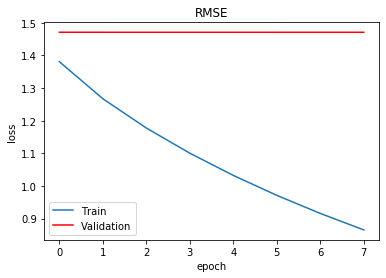

In [38]:
model.fit(train_set, val_set ,verbose=1, plot=True)

# Test

In [39]:
# RMSE on test set: 1.502049366563387 Without impl fb
# RMSE on test set: 1.5017974398979166 with impl fb
model.test(test_set)

RMSE on test set: 1.4506875950338802


## Store and Locate

In [25]:
model.store_results('', 'df_comparison_impl_fb')

new results created


In [30]:
pd.read_pickle('df_comparison_impl_fb')

,RMSE_test,train_speed,nolf,n_epochs,random_state,alpha,alpha_b,use_bias,use_impl_fb,use_i_attributes,bu_reg,bi_reg,pu_reg,qi_reg,x_reg,u_thres,i_thres,train_size,test_size,train_rmse
0,1.501797,5625.96,15,50,1234,0.004,0.04,True,True,True,0.005,0.005,0.01,0.01,0.1,NaN,NaN,706908,176728,"[1.3125411119422474, 1.1917518178753823, 1.114..."
1,1.502049,827.72,15,50,1234,0.004,0.04,True,False,True,0.005,0.005,0.01,0.01,0.1,NaN,NaN,706908,176728,"[1.3305246764064667, 1.2242818567165727, 1.151..."


# Cross Validation

In [ ]:
params = {"nolf":15, #Size of latent feature vectors
"n_epochs":10,
"random_state":1234,

#Learning rate
"alpha":0.004, #Low alpha to prevent diverging => sgd all over the place => error up
"alpha_b":0.004,

"use_bias":True,
"use_impl_fb":True,

#Regularizers, still tweaking the values
"bu_reg":0.5,
"bi_reg":0.5,
"pu_reg":0.001,
"qi_reg":0.001,
"x_reg":0.8,
}

In [ ]:
cv_res_name = 'cv_res_impl_fb'

In [ ]:
x_regs = [0, 0.001, 0.1, 0.5, 1, 5, 10, 20, 100, 500]
nolfs = [5,10,15,30,50]

for x_reg in x_regs:
    for nolf in nolfs:
        params['x_reg'] = x_reg
        params['nolf'] = nolf

        print('\n', params['x_reg'], params['nolf'], '\n')

        n_splits = 5

        kf = KFold(n_splits = n_splits, shuffle = True)
        full_data = df_new_ids
        scores = []

        for i in range(n_splits):
            result = next(kf.split(full_data), None)
            train_set = full_data.iloc[result[0]]
            test_set = full_data.iloc[result[1]]
            model = SVD(params)
            model.fit(train_set, total_users, total_items, verbose = 1000, plot = False)

            model.test(test_set)
            model.store_results('', 'one_cv_run_res_impl', user_thres, item_thres)  

        df_cv_results = pd.read_pickle('one_cv_run_res_impl')[-5:]
        params_dict = df_cv_results.iloc[0][['nolf', 'n_epochs', 'random_state', 'alpha', 'alpha_b', 'use_bias', 'use_impl_fb', 'bu_reg', 'bi_reg', 'pu_reg', 'qi_reg', 'x_reg', 'u_thres', 'i_thres', 'train_size', 'test_size', 'train_rmse']].to_dict()
        avg_rmse_dict = {'avg_rmse_test':np.average(df_cv_results['RMSE_test'])}
        final_dict = {**avg_rmse_dict, **params_dict}

        if not os.path.exists(res_name):
            cv_res = pd.DataFrame(columns=final_dict.keys())
            print('new results created')

        else:
            cv_res = pd.read_pickle(res_name)
            print('results added')

        cv_res = cv_res.append(final_dict, ignore_index=True)
        pd.to_pickle(cv_res, res_name)

In [ ]:
df_cv_results = pd.read_pickle(res_name).sort_values('avg_rmse_test')
df_cv_results

# Appendix

In [ ]:
# def create_matrix(self, X_train):
#         r = X_train['new_user_id']
#         c = X_train['new_item_id']
#         d = X_train['rating'].astype(int)
#         train_matrix = sparse.coo_matrix((d, (r, c)), shape=(self.total_users, self.total_items))
# #         print('train matrix shape: ', train_matrix.shape)

#         return train_matrix
    
#     def create_N(self, train_set, total_users, total_items):
#         if __name__ ==  '__main__': 
#             N1 = []
#             N2 = []
#             N3 = []

#             train_matrix = create_matrix(train_set, total_users, total_items).tocsr()

#             cutoff2 = int(np.floor(train_matrix.shape[0]/3))
#             cutoff3 = int(cutoff2 + cutoff2)
#             train_matrix1 = train_matrix.tocsr()[0:int(cutoff2),]
#             train_matrix2 = train_matrix.tocsr()[cutoff2:cutoff3,]
#             train_matrix3 = train_matrix.tocsr()[cutoff3:,]

#             inputs = [(1, N1, cutoff2, train_matrix1),
#                      (2, N1, cutoff2, train_matrix2),
#                      (3, N1, cutoff2 + 1, train_matrix3)]

#             num_processors = 3
#             p=Pool(processes = num_processors)
#             output = p.starmap(workers.worker, inputs)

#             N = []
#             for o in output:
#                 N.extend(o)

#             self.N = N
